In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as ms
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_roc_curve, roc_curve, auc

url = 'https://raw.githubusercontent.com/tannerskluz/SpotifyClassifier/main/data.csv'
df = pd.read_csv(url)
labels = df['explicit']
df.drop(columns=['id', 'name', 'artists', 'release_date', 'explicit','duration_ms',
    'key', 'liveness', 'mode', 'tempo', 'valence', 'loudness', 'instrumentalness'],inplace=True)
df.head()

,acousticness,danceability,energy,popularity,speechiness,year
0,0.991000,0.598,0.224,12,0.0936,1920
1,0.643000,0.852,0.517,7,0.0534,1920
2,0.993000,0.647,0.186,4,0.1740,1920
3,0.000173,0.730,0.798,17,0.0425,1920
4,0.295000,0.704,0.707,2,0.0768,1920


In [2]:
clf = Perceptron(tol=1e-6, random_state=10)
scaler = StandardScaler()
clf_mlp = make_pipeline(scaler, MLPClassifier(hidden_layer_sizes=(10, 5), random_state=1, max_iter = 1000))

# generate synthetic samples from minority class using kNN
sm = SMOTE(random_state=0, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(df, labels)

X_train, X_test, y_train, y_test = ms.train_test_split(X_res, y_res, random_state=0)


scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

clf.fit(X_train, y_train)
display("Perceptron Train-test split score: " + str(clf.score(X_test, y_test)))

mlp_score = clf_mlp.fit(X_train, y_train)
display("MLP Train-test split score: " + str(clf_mlp.score(X_test, y_test)))

strat_k_fold = StratifiedKFold(n_splits=5)

score = cross_val_score(clf, X_res, y_res, cv=strat_k_fold, scoring='accuracy').mean()
display("Perceptron accuracy with 5-fold cross validation score: " + str(score))
score = cross_val_score(clf_mlp, X_res, y_res, cv=strat_k_fold, scoring='accuracy').mean()
display("MLP accuracy with 5-fold cross validation score: " + str(score))


'Perceptron Train-test split score: 0.8436507741157359'

'MLP Train-test split score: 0.8965958598961282'

'Perceptron accuracy with 5-fold cross validation score: 0.6416153309272796'

'MLP accuracy with 5-fold cross validation score: 0.8893955000061835'

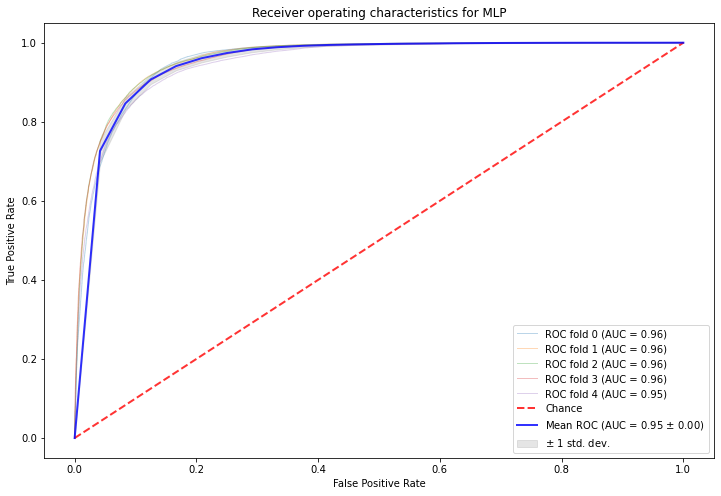

In [4]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 25)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
for i, (train, test) in enumerate(strat_k_fold.split(X_res, y_res)):
    clf_mlp.fit(X_res.iloc[train], y_res.iloc[train])
    viz = plot_roc_curve(clf_mlp, X_res.iloc[test], y_res.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristics for MLP")
ax.legend(loc="lower right")
plt.show()